# SFC-PHY Mapping Problem Explained | Python Version
SFC Graph and PHY Graph implementation and visualization with NetworkX.
Solving problem with PuLP.

## Prepare
Import required libraries.

In [1]:
# Variables
input = "./"
output = "./"

In [2]:
# Install
# %pip install networkx
# %pip install pulp

# Imports
import networkx as nx
import pulp as pulp
from pulp import *
import matplotlib.pyplot as plt
import fnmatch

problemName = "SFC-PHY-mapping-2"

problem = LpProblem(problemName, LpMinimize)

input = os.path.join(input, "input")
output = os.path.join(output, "output")

if not os.path.exists(input):
    raise Exception("No input!")

try:
    if os.path.exists(output):
        for f in os.listdir(output):
            os.remove(f"{output}/{f}")
    else:
        os.mkdir(output)
except OSError as error:
    print(error)


## Input Graph and Visualization
Graph implementation
- SFC: directed graph
- PHY: undirected graph

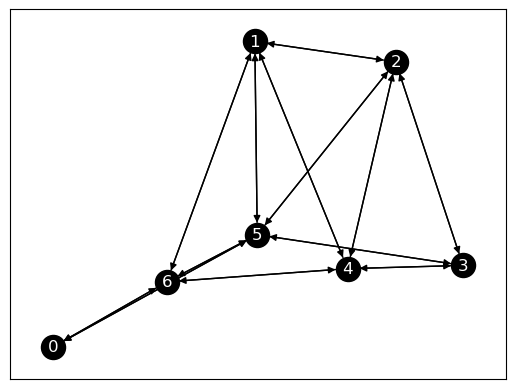

In [3]:
# PHY
G = nx.read_gml(f"{input}/phy.gml")

# Visualization
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, node_color='k', edge_color='k', font_color='w', with_labels=True)
# nx.draw(G, pos=plt.circular_layout(G), node_color='r', edge_color='g', with_labels=True)


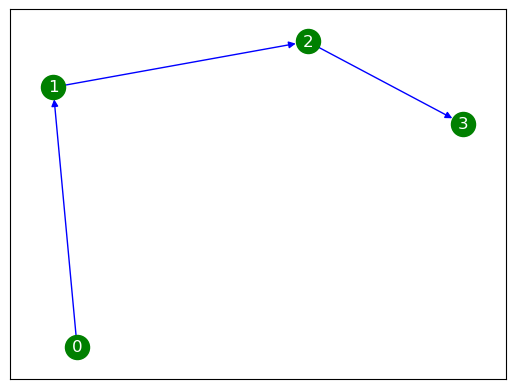

In [4]:
# SFC
file = fnmatch.filter(os.listdir(input), 'sfc_*.gml').pop()
GS = nx.read_gml(f"{input}/{file}")

# Visualization
pos = nx.spring_layout(G)
nx.draw_networkx(GS, pos=pos, node_color='g', edge_color='b', font_color='w', with_labels=True)

## Variables initialization
Fire up our variables!!!
$$ \phi_{i}^{v} = \begin{cases}
1 & \text{when } v \text{ is placed at }i\\
0 & \text{otherwise}
\end{cases} $$

$$ \phi_{ij}^{vw}=\begin{cases}
1 & \text{when }vw\text{ is placed at }ij\\
0 & \text{otherwise}
\end{cases} $$

In [5]:
# Build Node Placement List
phiNode = LpVariable.dicts(
    name="phiNode", 
    indices=(GS.nodes, G.nodes), 
    cat="Binary"
)
phiNode

{'0': {'0': phiNode_0_0,
  '1': phiNode_0_1,
  '2': phiNode_0_2,
  '3': phiNode_0_3,
  '4': phiNode_0_4,
  '5': phiNode_0_5,
  '6': phiNode_0_6},
 '1': {'0': phiNode_1_0,
  '1': phiNode_1_1,
  '2': phiNode_1_2,
  '3': phiNode_1_3,
  '4': phiNode_1_4,
  '5': phiNode_1_5,
  '6': phiNode_1_6},
 '2': {'0': phiNode_2_0,
  '1': phiNode_2_1,
  '2': phiNode_2_2,
  '3': phiNode_2_3,
  '4': phiNode_2_4,
  '5': phiNode_2_5,
  '6': phiNode_2_6},
 '3': {'0': phiNode_3_0,
  '1': phiNode_3_1,
  '2': phiNode_3_2,
  '3': phiNode_3_3,
  '4': phiNode_3_4,
  '5': phiNode_3_5,
  '6': phiNode_3_6}}

In [6]:
# Build Link Placement List
phiLink = LpVariable.dicts(
    name="phiLink",
    indices=(GS.edges, G.edges),
    cat="Binary"
)
phiLink

{('0', '1'): {('0', '5'): phiLink_('0',_'1')_('0',_'5'),
  ('0', '6'): phiLink_('0',_'1')_('0',_'6'),
  ('1', '4'): phiLink_('0',_'1')_('1',_'4'),
  ('1', '6'): phiLink_('0',_'1')_('1',_'6'),
  ('1', '5'): phiLink_('0',_'1')_('1',_'5'),
  ('1', '2'): phiLink_('0',_'1')_('1',_'2'),
  ('2', '5'): phiLink_('0',_'1')_('2',_'5'),
  ('2', '1'): phiLink_('0',_'1')_('2',_'1'),
  ('2', '4'): phiLink_('0',_'1')_('2',_'4'),
  ('2', '3'): phiLink_('0',_'1')_('2',_'3'),
  ('3', '4'): phiLink_('0',_'1')_('3',_'4'),
  ('3', '5'): phiLink_('0',_'1')_('3',_'5'),
  ('3', '2'): phiLink_('0',_'1')_('3',_'2'),
  ('4', '1'): phiLink_('0',_'1')_('4',_'1'),
  ('4', '2'): phiLink_('0',_'1')_('4',_'2'),
  ('4', '3'): phiLink_('0',_'1')_('4',_'3'),
  ('4', '6'): phiLink_('0',_'1')_('4',_'6'),
  ('5', '2'): phiLink_('0',_'1')_('5',_'2'),
  ('5', '0'): phiLink_('0',_'1')_('5',_'0'),
  ('5', '1'): phiLink_('0',_'1')_('5',_'1'),
  ('5', '3'): phiLink_('0',_'1')_('5',_'3'),
  ('5', '6'): phiLink_('0',_'1')_('5',_'6')

## Building Constraints
Build 5 constraints groups.

In [7]:
# clear any left-over data
problem.constraints.clear()


### Constraints Group 1: Node Capacity 
The total requested resources on a single node is under the maximum capacity of that node.
$$ \sum_{v\in\mathcal{N}_{s}}\phi_{i}^{v}.r_{v}\leq a_{i}\qquad\forall i\in\mathcal{N} $$

In [8]:
for node in G.nodes:
    problem += (
        lpSum(
            phiNode[nodeS][node] * nx.get_node_attributes(GS, "Req")[nodeS] for nodeS in GS.nodes) 
            <= nx.get_node_attributes(G, "Cap")[node]
            ,
            f"C1_i{node}"
        )


### Constraints Group 2: Link Capacity
Total requested resouces on a single link is under the maximun capacity of that link
$$ \sum_{vw\in\mathcal{E}_{s}}\phi_{ij}^{vw}.r_{vw}\leq a_{ij}\qquad\forall ij\in\mathcal{E} $$

In [9]:
for edge in G.edges:
    problem += (
        lpSum(
            phiLink[edgeS][edge] * nx.get_edge_attributes(GS, "Req")[edgeS]
            for edgeS in GS.edges
        ) 
        <= nx.get_edge_attributes(G, "Cap")[edge]
        , 
        f"C2_ij{edge}"
    )


### Constraints Group 3: Single VNF in Node
A node can only contain one VNF of a SFC.
$$ \sum_{v\in\mathcal{N}_{s}}\phi_{i}^{v}\leq1\qquad\forall i\in\mathcal{N} $$

In [10]:
for node in G.nodes:
    problem += (
        lpSum(
            phiNode[nodeS][node] for nodeS in GS.nodes) 
            <= 1
            , 
            f"C3_i{node}"
    )

### Constraints Group 4: No VNF is left behind
Every VNF is placed in a Node
$$ \sum_{i\in\mathcal{N}}\phi_{i}^{v}=1\qquad\forall v\in\mathcal{N}_{s} $$

In [11]:
for nodeS in GS.nodes:
    problem += (
        lpSum(
            phiNode[nodeS][node] for node in G.nodes
        )
        == 1
        , 
        f"C4_v{nodeS}"
    )

### Constraints Group 5: Flow Conservation
The Flow must be preserved
$$ \sum_{j\in\mathcal{N}}\phi_{ij}^{vw}-\sum_{j\in\mathcal{N}}\phi_{ji}^{vw}=\phi_{i}^{v}-\phi_{i}^{w}\qquad\forall i\in\mathcal{N},\forall vw\in\mathcal{E}_{s} $$

In [12]:
for i in G.nodes:
    for vw in GS.edges:
        problem += (
            (
                lpSum(phiLink[vw].get((i, j)) for j in G.nodes) 
                - lpSum(phiLink[vw].get((j, i)) for j in G.nodes)
            ) 
            == phiNode[vw[0]][i] - phiNode[vw[1]][i]
            , 
            f"C5_i{i}_vw{vw}"
        )


### Optional: Force put a VNF at a fixed Node
We can forcefully place a VNF in a node of PHY network.
$$ \phi_{i}^{v} = 1 $$

In [13]:
# Force starts at Node 4
# problem += phiNode[1][4] == 1
# Force ends at Node 7
# problem += phiNode[5][7] == 1

## Building objective function: Use minimum edges and nodes
Minimize the number of needed edges and nodes
$$ \min\left(\phi_{\mathcal{G}}^{\mathcal{G}_{s}}\right)=\min\left(\sum_{i\in\mathcal{N}}\sum_{v\in\mathcal{N}_{s}}\phi_{i}^{v}+\sum_{ij\in\mathcal{E}}\sum_{vw\in\mathcal{E}_{s}}\phi_{ij}^{vw}\right) $$

In [14]:
problem += (
    lpSum(
        lpSum(
            phiNode[v][i] for v in GS.nodes
        ) 
        for i in G.nodes
    ) 
    + lpSum(
        lpSum(
            phiLink[vw][ij]
            for vw in GS.edges
        ) 
        for ij in G.edges
    )
)

## Confirm before start
Double-check the whole inputs. (it's in the generated file)

In [15]:
problem.writeLP(filename=f"{output}/{problemName}.lp")

[phiLink_('0',_'1')_('0',_'5'),
 phiLink_('0',_'1')_('0',_'6'),
 phiLink_('0',_'1')_('1',_'2'),
 phiLink_('0',_'1')_('1',_'4'),
 phiLink_('0',_'1')_('1',_'5'),
 phiLink_('0',_'1')_('1',_'6'),
 phiLink_('0',_'1')_('2',_'1'),
 phiLink_('0',_'1')_('2',_'3'),
 phiLink_('0',_'1')_('2',_'4'),
 phiLink_('0',_'1')_('2',_'5'),
 phiLink_('0',_'1')_('3',_'2'),
 phiLink_('0',_'1')_('3',_'4'),
 phiLink_('0',_'1')_('3',_'5'),
 phiLink_('0',_'1')_('4',_'1'),
 phiLink_('0',_'1')_('4',_'2'),
 phiLink_('0',_'1')_('4',_'3'),
 phiLink_('0',_'1')_('4',_'6'),
 phiLink_('0',_'1')_('5',_'0'),
 phiLink_('0',_'1')_('5',_'1'),
 phiLink_('0',_'1')_('5',_'2'),
 phiLink_('0',_'1')_('5',_'3'),
 phiLink_('0',_'1')_('5',_'6'),
 phiLink_('0',_'1')_('6',_'0'),
 phiLink_('0',_'1')_('6',_'1'),
 phiLink_('0',_'1')_('6',_'4'),
 phiLink_('0',_'1')_('6',_'5'),
 phiLink_('1',_'2')_('0',_'5'),
 phiLink_('1',_'2')_('0',_'6'),
 phiLink_('1',_'2')_('1',_'2'),
 phiLink_('1',_'2')_('1',_'4'),
 phiLink_('1',_'2')_('1',_'5'),
 phiLink

## Let's the show begins
Fire the solver and wait for results. `Optimal` means that we found the solution. `Infeasible` means that we cannot solve the problem.

In [16]:
solver = pulp.PULP_CBC_CMD(msg=True, warmStart=True) # GNNN/RL/ML
status = problem.solve(solver)
LpStatus[status]
print(LpStatus[status])
print(problem.solutionTime)
if (LpStatus[status] == "Infeasible"):
    raise Exception("Infeasible")

Optimal
0.09622859954833984


v0 -> i2
v1 -> i3
v2 -> i5
v3 -> i1
vw('0', '1') -> ij('2', '3')
vw('1', '2') -> ij('3', '5')
vw('2', '3') -> ij('5', '1')


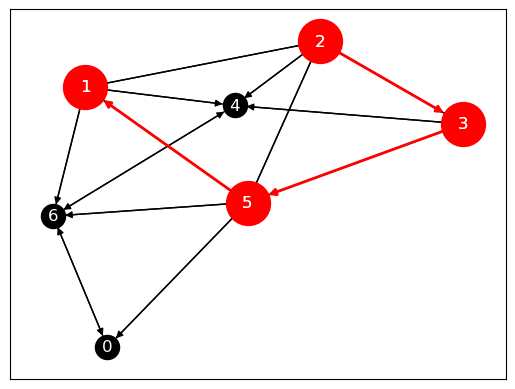

In [17]:
f=open(f"{output}/sfc.txt", "w+")
selectedNodes = list()
for v in GS.nodes:
    for i in G.nodes:
        if (value(phiNode[v][i])):
            print(f"v{v} -> i{i}")
            f.write(f"v{v} -> i{i}\n")
            selectedNodes.append(i)

selectedLinks = list()
for vw in GS.edges:
    for ij in G.edges:
        if (value(phiLink[vw][ij])):
            print(f"vw{vw} -> ij{ij}")
            f.write(f"vw{vw} -> ij{ij}\n")
            selectedLinks.append(ij)
f.close()
# GG = G.subgraph(selectedNodes)
GG = G.edge_subgraph(selectedLinks)
# pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, node_color='k', edge_color='k',
                 font_color='w', with_labels=True)
nx.draw_networkx(GG, pos=pos, node_color='r', edge_color='r',
                 font_color='w', with_labels=True, node_size=1000.0, width=2.0)
